# CAPSTONE 3. Predicting Major Cryptocurrencies Prices
## Preprocessing and Training Data Development

In this notebook we will perform preprocessing and training data development for the project. The goal of this process is to standardize our model development dataset. <br>
<br>
In the previous step we discovered that our Bitcoin pricing process is not stationary - it has a clear trend. We also tested the null hypothesis that Bitcoin pricing process is a random walk, performed Augmented Dickey-Fuller test and based on its results we <b>confidentely rejected</b> this hypothesis. In order to perform time series forecasting we will need to perform next steps:<br>
<ul>
    - <i>Remove trend</i><br>
    - <i>Remove seasonality</i>
</ul>
In other words, we will need to <b><i>make our time series stationary</i></b>. Since most of the time series forecasting are based on regression (for real values, like bitcoin price), this is an essential step for getting accurate predictions.
<br>
In preprocessing and training data development step we will build and train a baseline model - in this case it will be <b>Autoregressive Integrated Moving Average (ARIMA)</b> - which is a classic model for time series forecasting based on the assumption that previous values carry information about the process and can be used to predict future values. In following steps we will build more models and compare there performance.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import sklearn.model_selection
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_percentage_error

warnings.filterwarnings('ignore')

#setting default figure size
sns.set(rc={"figure.figsize":(12, 5)})
plt.rcParams['figure.figsize'] = (12, 5)

sns.set_style('whitegrid')

#showing only 2 decimals for floats
pd.options.display.float_format = "{:.3f}".format

In [2]:
# loading the data
df = pd.read_csv('../EDA/Data_for_PTDD.csv')
df_merged = pd.read_pickle('../EDA/df_merged.pkl')
btc = pd.read_pickle('../EDA/BTC.pkl')
eth = pd.read_pickle('../EDA/ETH.pkl')
xrp = pd.read_pickle('../EDA/XRP.pkl')
ltc = pd.read_pickle('../EDA/LTc.pkl')

### TRANSFORMING THE TIME SEREIS

Since our time series is not stationary, we will need to transform it into stationary one in order to apply machine learning models to it. Let's take a look at BTC price once again. 

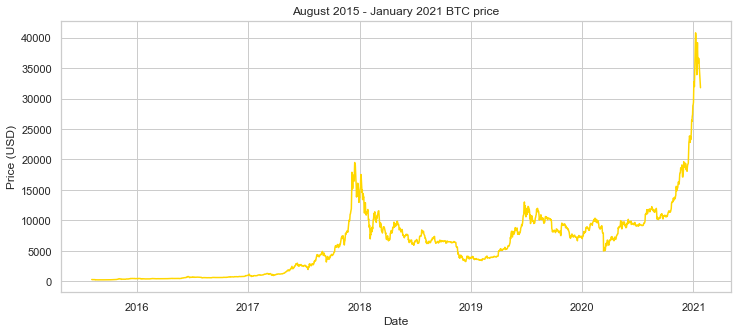

In [3]:
sns.lineplot(data=btc, x='Date', y='Close', color='Gold')
plt.title(f'August 2015 - January 2021 BTC price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

Although we don't necessarily see any seasonality, we can clearly see an upward trend. We will apply differencing method to our time-series - a method of removing the series dependence on time, which includes structures like trend and seasonality. Differencing is performed by subtracting the previous observation from the current observation. Pandas provides us with the necessary function.

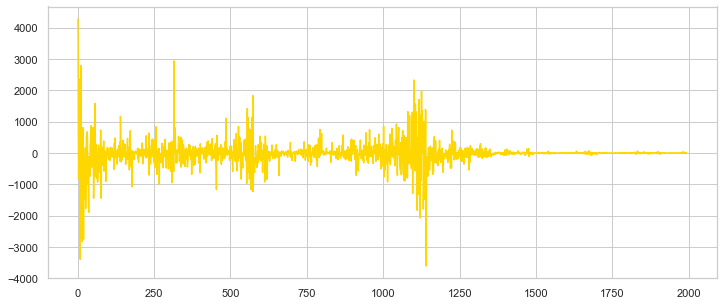

In [4]:
BTC_price = btc['Close']
BTC_diff = BTC_price.diff(periods=1)
plt.plot(BTC_diff, color='Gold')
plt.show();

It looks more stationary now. Let's check it with the ACF plot.

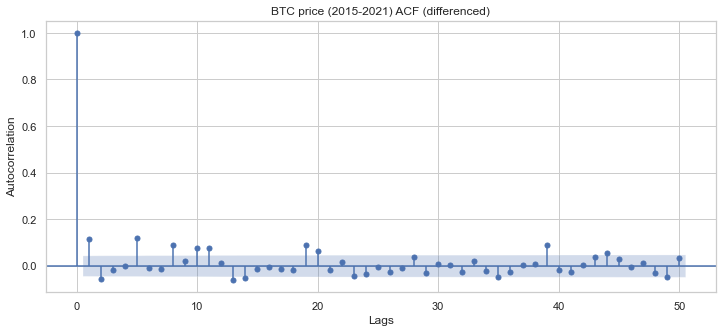

In [5]:
# plotting BTC_Price ACF
plot_acf(BTC_diff.dropna(), lags=50)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('BTC price (2015-2021) ACF (differenced)')
plt.show();

As we would expect for a stationary time series, the autocorrelation values degraded to zero very quickly. The plot confirms that the differencing method made our BTC price series <b>stationary</b>. <br>
<br>
<b><i>REMINDER:</i></b> our bitcoin price were collected using <b>daily</b> values. Thus, <b>each lag equals to one day</b>.

### ARIMA model

ARIMA stands for Auto Regressive Integrated Moving Average. As we can see, there are 3 components in this acronym:<br>
<ol>
    <ol>1. AR - Auto Regression - relationship between given observation and some lagged observation (or several observations).</ol>
    <ol>2. I - Integrated - the observations are differenced in order to make a time series stationary</ol>
    <ol>3. MA - Moving Average - relationship between given observation and a residual error from some lagged observation (or several observations).</ol>
</ol>
From those three parts of the model we can conclude that it takes 3 inputs:
<ol>
    <ol>1. p - Lag order - the number of lagged observations</ol>
    <ol>2. d - Degree of differencing - the number of times the observations are differenced</ol>
    <ol>3. q - Order of moving average - the size of moving average window
</ol>
<br>
Next question is how we can determine what orders should we use for those three inputs. We will use ACF to find out <i>q</i>, and PACF (Partial Autocorrelation Function) to find out <i>p</i>.

#### MA - Autocorrelation Function (ACF)

If we look at the graph of the ACF above, we can see that most of the values are withing that blue shaded area, which means they are not statistically difference from zero, and they degrade to zero quickly after the 1st lag. We will start with MA(1) for <i>q</i>

#### AR - Partial Autocorrelation Function (PACF)

PACF measures direct effect of some particular lagged observation to the given observation, skipping all the observations between them. Without goint too deep into the details, PACF will help us to determine input <i>p</i> for the Auto Regression part of our model.

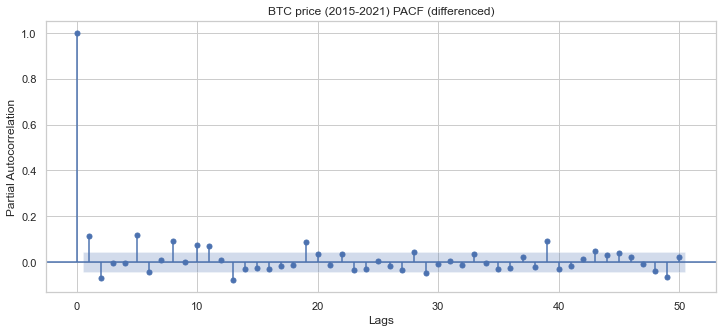

In [6]:
# plotting BTC_price PACF
plot_pacf(BTC_diff.dropna(), lags=50)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.title('BTC price (2015-2021) PACF (differenced)')
plt.show();

Here we can see that 2 observations in the beginning of X-axis that are statistically different from zero. Thus, let's use AR(2) for our <i>p</i>.

#### I - Differencing

We already differenced our time series and saw that using 1 as degree of differencing (periods=1) made it stationary. Thus, we will use I(1) for <i>d</i>

### Data Preprocessing

Now, after we determined inputs for our ARIMA model, we need to split our data into training and testing parts. However, we <b>CAN NOT</b> directly use train_test_split function, because it assumes there is no relationships between observations. In case of time series, this assumption is wrong. Instead, we will divide our time series into train-test split manually. For the test set we will use only last 30 observations (1 month).

In [10]:
btc_price = btc[['Date', 'Close']]
btc_price = btc_price.iloc[::-1]
btc_price.set_index('Date', inplace=True)

In [12]:
BTC_val = btc_price.values

Total Observations: 1994
Training Observations: 1964
Testing Observations: 30


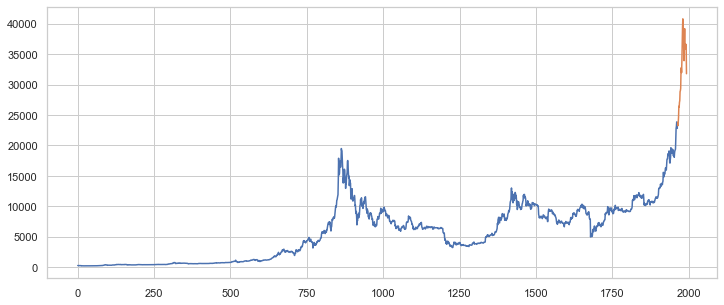

In [13]:
# train-test split
train_size = int(len(BTC_val) * 0.985)
train, test = BTC_val[0:train_size], BTC_val[train_size:len(BTC_val)]
print(f'Total Observations: {(len(BTC_val))}')
print(f'Training Observations: {(len(train))}')
print(f'Testing Observations: {(len(test))}')
plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.show()

Now we will normalize our data usning StandardScaler.

In [14]:
BTC_val = BTC_val.reshape((len(BTC_val), 1))
scaler = StandardScaler()
train = train.reshape(-1,1)
test = test.reshape(-1,1)
scaler = scaler.fit(train)
train_norm = scaler.transform(train)
test_norm = scaler.transform(test)

### Building ARIMA model with predetermined inputs

Now we will build ARIMA model, train and evaluate it. For our first trial we will use the (p,d,q) order we determined earlier - (2,1,1)

In [15]:
ARIMA_model = ARIMA(train_norm, order = (2,1,1))
ARIMA_fit = ARIMA_model.fit()
ARIMA_errors = pd.DataFrame(ARIMA_fit.resid)
print(ARIMA_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1964
Model:                 ARIMA(2, 1, 1)   Log Likelihood                2433.291
Date:                Sat, 24 Jul 2021   AIC                          -4858.583
Time:                        18:10:18   BIC                          -4836.254
Sample:                             0   HQIC                         -4850.376
                               - 1964                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7302      0.107     -6.806      0.000      -0.940      -0.520
ar.L2         -0.0059      0.013     -0.469      0.639      -0.031       0.019
ma.L1          0.7638      0.106      7.176      0.0

We can see that the first AR coefficient is -0.7302, which suggest the current time series value is strongly negatively correlated with time series values 1 lag before. The second lag has very small correlation, as well as sigma. MA part shows that it has moderate positive correlation with a current value. The P-values are all very small, which means all 4 of these coefficients have significant predictive power.

Let's take a look at the residuals we got on the train set.

In [ ]:
print("====== TRAIN SET ERRORS ======")
print(ARIMA_errors.describe())

In [ ]:
sns.kdeplot(data=ARIMA_errors);

The mean of the errors is 0, which indicates there is no structure not caught by the model.

### Predicting future values using ARIMA

Now, after we fitted the model, we can use it to predict future values of the timeseries. We will use forecast() function on every element of the test set and store them in a list. We will also create a list with train set observations. At the end we will plot the expected values vs predicted values and see how our model did.

In [ ]:
predictions_test = [] # List where all the predicted values will be stored
observations_test = [x for x in train_norm] # List with train set values

In [ ]:
for i in range(len(test_norm)):
    ARIMA_model = ARIMA(observations_test, order=(2,1,1))
    ARIMA_fit = ARIMA_model.fit()
    ARIMA_forecast = ARIMA_fit.forecast()
    ypred = ARIMA_forecast[0]
    predictions_test.append(ypred)
    exp_val = test_norm[i]
    observations_test.append(exp_val)

We have our predictions. Now let's find out the r-squared and Mean Absolute Percentage Error for our test set.

In [ ]:
r2 = r2_score(test_norm, predictions_test)
print(f'Test set r-squared for ARIMA(2,1,1) is: {round(r2, 2)}')
mape = mean_absolute_percentage_error(test_norm, predictions_test)
print(f'Test set MAPE for ARMIA(2,1,1) is: {round(mape,2) * 100}%')

We can see that 98% of the target's variance explained by the feautures. And we see that MAPE is indeed just 2%. Errors are very small.

Now let's plot predictions vs residuals

In [ ]:
plt.plot(test_norm, label='Expected')
plt.plot(predictions_test, label='Predicted', color='red', alpha=0.5)
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Train set Predicted vs Expected")
plt.show()

As we can see from the graph, our ARIMA(2,1,1) model did quite well. The lines are very close to each other.

Let's look at the test set scatterplot

In [ ]:
test_norm = test_norm.flatten() # making the array one-dimensional

In [ ]:
exp_pred_test_df = pd.DataFrame({'Expected':test_norm,'Predicted':predictions_test}) # combining expected and predicted values in one dataframe

In [ ]:
def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None,
            linestyle='--', linewidth=1.0)

In [ ]:
grid = sns.scatterplot(x='Predicted', y='Expected', data=exp_pred_test_df)
plt.title('Test set Predicted vs Expected values')
plot_unity(exp_pred_test_df['Predicted'], exp_pred_test_df['Expected'])

We see on the graph that residuals lay close to the reference line. In ideal model with 100% accuracy they would be all on the line. However, our ARIMA(2,1,1) still shows great results.

Now we will do the same process, but for the train set.

In [ ]:
predictions_train = []
observations_train = [x for x in train_norm]

In [ ]:
for i in range(len(train_norm)):
    ARIMA_model = ARIMA(observations_train, order=(2,1,1))
    ARIMA_fit = ARIMA_model.fit()
    ARIMA_forecast = ARIMA_fit.forecast()
    ypred = ARIMA_forecast[0]
    predictions_train.append(ypred)
    exp_val = train_norm[i]
    observations_train.append(exp_val)
    
r2 = r2_score(train_norm, predictions_train)
print(f'Train set r-squared for ARIMA(2,1,1) is: {round(r2, 2)}')
mape = mean_absolute_percentage_error(train_norm, predictions_train)
print(f'Train set MAPE for ARMIA(2,1,1) is: {round(mape,2) * 100}%')

The r-squared is the same while percentage error went down to 1%.

Let's plot test set predictions vs expected.

In [ ]:
plt.plot(train_norm, label='Expected')
plt.plot(predictions_train, label='Predicted', color='red', alpha=0.5)
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title('Train set predicted vs expected values')
plt.show()

Let's look at the train set scatterplot

In [ ]:
train_norm = train_norm.flatten()
exp_pred_train_df = pd.DataFrame({'Expected':train_norm,'Predicted':predictions_train})

In [ ]:
grid = sns.scatterplot(x='Predicted', y='Expected', data=exp_pred_train_df)
plt.title('Train set Predicted vs Expected values')
plot_unity(exp_pred_train_df['Predicted'], exp_pred_train_df['Expected'])

There are some outluers, but in general resuduals are very small.

Here is a table with ARIMA(2,1,1) model summary. Overall, the model achieved very high accuracy.

| MODEL | ORDER | OBSERVATIONS | r-squared | MAPE |
| ------| ----- | -------------|---- | ---- | 
| ARIMA (test set) | (2,1,1) | 30 | 0.98 | 2% |
| ARIMA (train set) | (2,1,1)| 1994| 0.98  |1% |

## Conclusion

In this step we prepared out data for model development. We scaled it, split it into training and testing sets, plotted ACF and PACF which allowed us to pick (2,1,1) order for our ARIMA model. We then fitted the model on the training set and predicted values for our test set. Then we calculated MSRE ($224.7) and plotted a graph of Expected vs Predicted values. It turned out our model did quite well with the order we derived from the ACF and PACF.<br>
In next step we will perform ARIMA hyperparameter tuning and build another models. We will evaluate them and decide which one is better for our purpose.

In [ ]:
# saving the data
datapath = 'D://Prog/SDST/My Projects/Capstone3/PTDD'
if not os.path.exists(datapath):
    os.mkdir(datapath)
datapath_PTDD = os.path.join(datapath, 'Data_for_Modeling.csv')
if not os.path.exists(datapath_PTDD):
    df.to_csv(datapath_PTDD, index=False)
df.to_pickle("./df.pkl")
df_merged.to_pickle("./df_merged.pkl")
btc = df.to_pickle("./btc.pkl")
filename = 'ARIMA(2,1,1).sav'
pickle.dump(ARIMA_model, open(filename, 'wb'))
np.save("train_norm", train_norm)
np.save("test_norm", test_norm)